### An ipython notebook that implements the MLE (and other) powerlaw fits

Accompanies *Frequency-dependent activity in FRB 20201124A* by Bilous et al., https://arxiv.org/abs/2407.05366


### Contents:
    -- A) Defining necessary functions and classes
    -- B) Calculations and plots the results of power-law index estimation against sample size (Fig. A.1).
    -- C) Calculations and plots the distribution of fit accuracy statistic against the sample size (Fig. A.3-A.4).
    -- D) Demonstration that power-law indices measured with MLE method are described by gamma distribution.    

A) Defining necessary functions and classes

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pareto

In [2]:
def simulate_power_law_rv(alpha: float, num_points: int = 100) -> np.ndarray:
    """
    Simulates power-law distributed random variables.

    Parameters:
    alpha (float): The shape parameter of the power-law distribution.
    num_points (int): The number of data points to generate. Default is 100.

    Returns:
    np.ndarray: Sorted array of power-law distributed random variables.
    """
    y = pareto.rvs(-alpha, size=num_points)
    y = np.sort(y)
    return y

In [3]:
def get_survival_function(y: np.ndarray) -> np.ndarray:
    """
    Computes the survival function for the given data sample. Survival function is defined
    as number of data points that are not smaller than the threshold value.

    Parameters:
    y (np.ndarray): Array of data points.

    Returns:
    np.ndarray: Survival function values corresponding to the data points.
    """
    # Compute the survival function by counting the number of values greater than or equal to each y_i
    SF = np.array([len(y[y >= y_i]) for y_i in y])
    return SF

In [4]:
def fit_power_law_lstsq(y: np.ndarray) -> tuple:
    """
    Fits a power-law distribution (linear function in log-log space) to data using a least squares method.

    Parameters:
    y (np.ndarray): Array of data points.

    Returns:
    tuple: Slope and slope error of the fitted power-law.
    """
    SF = get_survival_function(y)
    log_SF = np.log(SF)
    log_y = np.log(y) - np.mean(np.log(y))

    coeffs, cov_matrix = np.polyfit(log_y, log_SF, 1, cov=True)
    slope, _ = coeffs

    # Calculate the standard error of the slope from the covariance matrix
    slope_err = np.sqrt(np.diag(cov_matrix))[0]
    return slope, slope_err

In [5]:
def bootstrap_slope_errors(
    y: np.ndarray, num_bootstrap: int = 20, plot_slopes: bool = False
) -> float:
    """
    Estimates the error of the slope of the fitted power-law using bootstrap method.

    Parameters:
    y (np.ndarray): Array of PL-distributed data points.
    num_bootstrap (int): Number of bootstrap samples. Default is 20.
    plot_slopes (bool): If True, plots the bootstrap samples and histogram of slopes. Default is False.

    Returns:
    float: Standard deviation of the slopes from bootstrapped samples.
    """
    slopes = np.zeros(num_bootstrap)

    # Determine the size of each bootstrap sample
    if len(y) <= 10:
        size = len(y) - 1
    else:
        size = int(0.9 * len(y))

    SF_bootstrap = np.zeros((size, num_bootstrap), dtype=float)
    y_bootstrap = np.zeros((size, num_bootstrap), dtype=float)

    for i in range(num_bootstrap):
        # Shuffle the data to create a bootstrap sample
        np.random.shuffle(y)
        y_bootstrap[:, i] = np.sort(y[:size][::-1])
        SF_bootstrap[:, i] = get_survival_function(y_bootstrap[:, i])
        slopes[i], _ = fit_power_law_lstsq(y_bootstrap[:, i])

    if plot_slopes:
        # Plot the survival functions of bootstrap samples if requested
        plt.figure()
        plt.subplot(121)
        for i in range(num_bootstrap):
            plt.plot(y_bootstrap[:, i], SF_bootstrap[:, i], "k-", lw=0.1)
        plt.loglog()
        plt.xlabel("Bootstrapped random variable")
        plt.ylabel("Survival function")
        plt.subplot(122)
        # Plot a histogram of the slopes from bootstrap samples if requested
        plt.hist(slopes, bins=50)
        plt.xlabel("Fitted bootstrapped PLI")
        plt.show()

    # Compute the standard deviation of the slopes as the bootstrap error
    bootstrap_slope_error = np.std(slopes)

    return bootstrap_slope_error

In [6]:

# The following formulae for calculating power-law index and its uncertainty can
# be directly implemented in power-law package v.1.5.
# In the file powerlaw.py
# in the definition of class Power_Law(Distribution):
# around line 1160, substitute
# self.alpha = 1 + (self.n / sum(log(data/self.xmin)))
# with
# self.alpha = 1 + ((self.n-1) / sum(log(data/self.xmin))
# For alpha uncertainty, substitute around line 1140
# return (self.alpha - 1) / sqrt(self.n)
# with
# return (self.alpha - 1) / sqrt(self.n-2)

def fit_power_law_MLE(y: np.ndarray, ymin: float = None) -> tuple:
    """
    Fits a power-law distribution to data using Maximum Likelihood Estimation (MLE).
    Unbiased estimates of slope and its error are used, see James et al. (2019),
    arXiv:1810.04357.

    Parameters:
    y (np.ndarray): Array of PL-distributed data points.
    ymin (float): Minimum value for fitting. Default is the minimum value in y.

    Returns:
    tuple: Slope and slope error of the fitted power-law.
    """
    if ymin is None:
        # Set ymin to the minimum value in y if not provided
        ymin = np.min(y)
    N = len(y)
    a_inv = -1.0 / (N - 1) * np.sum(np.log(y / ymin))
    a = a_inv**-1
    a_err = -a / np.sqrt(N - 2)
    return a, a_err

In [7]:
def fit_power_law_powerlaw(
    y: np.ndarray, xmin: float = None, rescale: bool = False
) -> tuple:
    """
    Fits a power-law distribution to data using the powerlaw package.

    Parameters:
    y (np.ndarray): Array of data points.
    xmin (float): Minimum value for fitting. Default is None.
    rescale (bool): If True, rescales the slope. Default is False.

    Returns:
    tuple: Slope and slope error of the fitted power-law.
    """
    import powerlaw as pl

    N = len(y)  # Number of data points
    # Use the powerlaw package to fit the data
    fit = pl.Fit(y, xmin=xmin)
    a_pl = fit.power_law.alpha
    a_err = fit.power_law.sigma

    if rescale:
        # Rescale the slope and its error if requested
        a_pl = (a_pl - 1) / N * (N - 1) + 1
        a_err = a_err * (N - 1) / (N * np.sqrt(N - 2))

    a = -(a_pl - 1)
    return a, a_err

In [8]:
class ExaminePowerLawFits:
    """
    A class to examine power-law fits using different fitting methods and calculate deviations from the true slope.

    Attributes:
    alpha (float): The true slope of the power-law distribution.
    sample_size_grid (np.ndarray): Array of sample sizes to consider.
    num_trials (int): Number of trials to perform for each sample size.
    percentiles (list): Percentiles to compute for the deviation distribution.
    label (str): Label describing fitting method.
    """
    
    def __init__(self, alpha=-2, sample_size_grid=None, num_trials=100):
        """
        Initializes the ExaminePowerLawFits class with the given parameters.

        Parameters:
        alpha (float): The true slope of the power-law distribution. Default is -2.
        sample_size_grid (np.ndarray): Array of sample sizes to consider. Default is None, which sets a default grid.
        num_trials (int): Number of trials to perform for each sample size. Default is 100.
        """
        
        if sample_size_grid is None:
            sample_size_grid = np.round(
                np.logspace(np.log10(5), np.log10(500), 20)
            ).astype(int)
        self.sample_size_grid = sample_size_grid
        self.alpha = alpha
        self.num_trials = num_trials
        self.percentiles = [0.1, 2.3, 16, 50, 84, 97.7, 99.9]

    def calculate_fit_deviation(self, method="lstsq"):
        """
        Calculates the deviation of the fitted power-law slope from the true slope using different fitting methods.

        Parameters:
        method (str): The fitting method to use. Options are "lstsq", "lstsq_bootstrap_err", "direct_MLE", 
                      "powerlaw", "powerlaw_rescaled", "powerlaw_xmin_fit". Default is "lstsq".

        Returns:
        dict: A dictionary containing the method, label, deviation percentiles, percentiles used, and sample sizes.
        """

        num_sample_size = len(self.sample_size_grid)
        num_trials = self.num_trials
        sample_size_grid = self.sample_size_grid

        alpha = self.alpha
        dev = np.zeros((num_sample_size, num_trials), dtype=float)

        for i_ss, n in enumerate(sample_size_grid):

            for i_tr in range(num_trials):
                y = simulate_power_law_rv(alpha, num_points=n)

                if method == "lstsq":
                    slope, slope_err = fit_power_law_lstsq(y)
                    self.label = "Least Squares\n"
                elif method == "lstsq_bootstrap_err":
                    slope, _ = fit_power_law_lstsq(y)
                    slope_err = bootstrap_slope_errors(y, num_bootstrap=20)
                    self.label = "Least Squares,\nbootstrap error"
                elif method == "direct_MLE":
                    slope, slope_err = fit_power_law_MLE(y)
                    self.label = "Maximum Likelihood\nEstimator"
                elif method == "powerlaw":
                    slope, slope_err = fit_power_law_powerlaw(y, xmin=np.min(y))
                    self.label = "Original powerlaw"
                elif method == "powerlaw_rescaled":
                    slope, slope_err = fit_power_law_powerlaw(
                        y, xmin=np.min(y), rescale=True
                    )
                    self.label = "Rescaled powerlaw"
                elif method == "powerlaw_xmin_fit":
                    slope, slope_err = fit_power_law_powerlaw(
                        y, xmin=None, rescale=False
                    )
                    self.label = "powerlaw with\nxmin fit"
                else:
                    print("Unsupported method")
                    exit(1)

                dev[i_ss, i_tr] = (slope - alpha) / slope_err

        dev_perc = np.percentile(dev, self.percentiles, axis=1)

        dev_dict_corr = {
            "method": method,
            "label": self.label,
            "deviation": dev_perc,
            "percentiles": self.percentiles,
            "samples": self.sample_size_grid,
        }

        return dev_dict_corr

In [9]:
def plot_figure_PLI_lstsq_vs_sample_size(
    alpha: float,
    num_points: float,
    num_realizations: float,
    ys: np.ndarray,
    SFs: np.ndarray,
    y_theory: np.ndarray,
    SF_theory: np.ndarray,
    slope: np.ndarray,
    slope_err: np.ndarray,
    slope_bootstrap_err: np.ndarray,
) -> None:
    """
    Plots the results of power-law index estimation against sample size (Fig. A.1).

    Parameters:
    alpha (float): The true power-law index.
    num_points (float): Number of PL-distributed data points.
    num_realizations (float): Number of sample realizations.
    ys (np.ndarray): Simulated data points.
    SFs (np.ndarray): Survival functions of the data points.
    y_theory (np.ndarray): Grid for computing analytical survival function.
    SF_theory (np.ndarray): Analytical survival function.
    slope (np.ndarray): Estimated PL indices.
    slope_err (np.ndarray): Errors of the estimated PL indices.
    slope_bootstrap_err (np.ndarray): Bootstrap errors of the estimated PL indices.
    """

    plt.figure(figsize=(7, 5))
    ax_facecolor = "0.93"
    cls = ["DarkMagenta", "DarkOrange", "DarkGreen"]
    ax = plt.subplot2grid(
        (1, 2), (0, 0), title="Power-law distributed\nrandom variable"
    )
    ax.set_facecolor(ax_facecolor)
    for i in range(num_realizations):
        plt.plot(ys[i, :], SFs[i, :], ".-", markersize=5, lw=1, zorder=10, color=cls[i])
    plt.plot(y_theory, SF_theory, "k", lw=1, ls=":", zorder=9)
    plt.annotate(
        r"$\alpha_\mathrm{true} = -2$", (8, 20), color="k", horizontalalignment="center"
    )
    plt.loglog()
    plt.xlim(0.9, np.max(ys) * 1.1)
    plt.ylim(0.92, 1.2 * num_points)
    plt.grid(which="both", color="w")
    plt.xlabel("$X_0$")
    plt.ylabel("$N(X x X_0)$")

    ax = plt.subplot2grid((1, 2), (0, 1), title="Least-squares\npower-law index")
    ax.set_facecolor(ax_facecolor)
    for i in range(num_realizations):

        y = ys[i, :]
        SF = SFs[i, : -min_num_points + 1]
        slope = slopes[i, : -min_num_points + 1]
        slope_err = slopes_err[i, : -min_num_points + 1]
        slope_bootstrap_err = slopes_bootstrap_err[i, : -min_num_points + 1]

        plt.plot(slope, SF, ".-", markersize=2, lw=0.8, color=cls[i], zorder=5)
        plt.fill_betweenx(
            SF,
            slope - slope_bootstrap_err,
            slope + slope_bootstrap_err,
            lw=0.8,
            color=cls[i],
            zorder=4,
            alpha=0.2,
        )
        plt.fill_betweenx(
            SF,
            slope - slope_err,
            slope + slope_err,
            lw=0.8,
            color=cls[i],
            zorder=3,
            alpha=0.5,
        )

    plt.axvline(alpha, lw=1, ls=":", color="k", zorder=3)
    plt.semilogy()
    plt.xlim(alpha - 2, alpha + 2)
    plt.xticks(np.arange(-4, 0, 0.5))
    plt.ylim(0.92, 1.2 * num_points)

    plt.annotate(
        "darker shade: least squares error",
        (-3.9, 1.1),
        color="k",
        horizontalalignment="left",
        fontsize=8,
    )  # , fontweight='bold')
    plt.annotate(
        "lighter shade: bootstrap error",
        (-3.9, 1.5),
        color="k",
        horizontalalignment="left",
        fontsize=8,
    )

    plt.grid(which="both", color="w")
    plt.xlabel(r"$\alpha_\mathrm{meas}$")
    plt.ylabel("$N(X x X_0)$")
    ax.yaxis.tick_right()
    ax.yaxis.set_label_position("right")

    plt.show()


B) The following code performs calculations and plots the results of power-law index estimation against sample size (Fig. A.1).

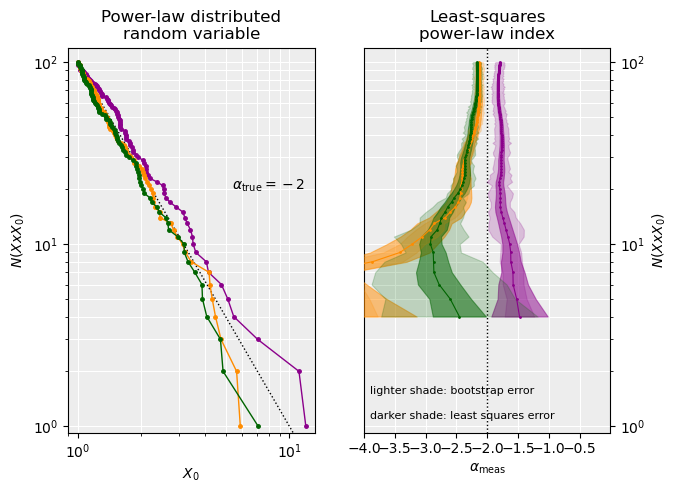

In [10]:
# Setting up simulation parameters
alpha = -2.0
num_realizations = 3
num_points = 100
num_bootstrap = 100
min_num_points = 4

SFs = np.zeros((num_realizations, num_points), dtype=float)
ys = np.zeros((num_realizations, num_points), dtype=float)
slopes = np.zeros((num_realizations, num_points), dtype=float)
slopes_err = np.zeros((num_realizations, num_points), dtype=float)
slopes_bootstrap_err = np.zeros((num_realizations, num_points), dtype=float)

for i in range(num_realizations):
    ys[i, :] = simulate_power_law_rv(alpha, num_points)
    SFs[i, :] = get_survival_function(ys[i, :])
    for j in np.arange(num_points - min_num_points, -1, -1):
        y_trunc = np.copy(ys[i, j:])
        slopes[i, j], slopes_err[i, j] = fit_power_law_lstsq(y_trunc)
        slopes_bootstrap_err[i, j] = bootstrap_slope_errors(
            y_trunc, num_bootstrap, plot_slopes=False
        )

y_theory = np.linspace(1, np.max(ys), 100)
SF_theory = num_points * y_theory**alpha

# Making figure
plot_figure_PLI_lstsq_vs_sample_size(
    alpha,
    num_points,
    num_realizations,
    ys,
    SFs,
    y_theory,
    SF_theory,
    slopes,
    slopes_err,
    slopes_bootstrap_err,
)

C) The following code performs calculations and plots the distribution of fit accuracy statistic against the sample size (Fig. A.3-A.4).

Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best min

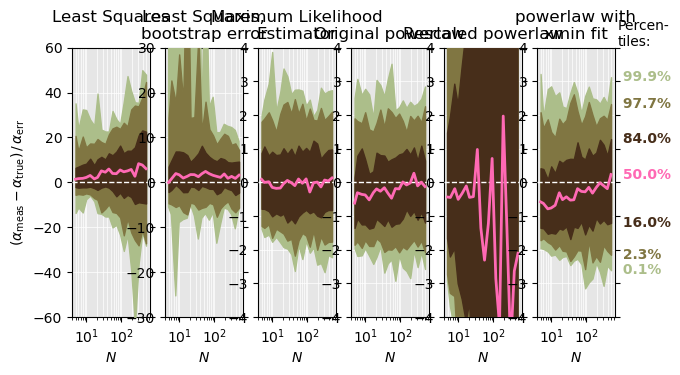

242 242 60
242 242 61
242 242 62
242 242 63
242 242 64
242 242 65
242 242 66
242 242 67
242 242 68
242 242 69
242 242 70
242 242 71
242 242 72
242 242 73
242 242 74
242 242 75
242 242 76
242 242 77
242 242 78
242 242 79
242 242 80
242 242 81
242 242 82
242 242 83
242 242 84
242 242 85
242 242 86
242 242 87
242 242 88
242 242 89
242 242 90
242 242 91
242 242 92
242 242 93
242 242 94
242 242 95
242 242 96
242 242 97
242 242 98
242 242 99
308 308 0
308 308 1
308 308 2
308 308 3
308 308 4
308 308 5
308 308 6
308 308 7
308 308 8
308 308 9
308 308 10
308 308 11
308 308 12
308 308 13
308 308 14
308 308 15
308 308 16
308 308 17
308 308 18
308 308 19
308 308 20
308 308 21
308 308 22
308 308 23
308 308 24
308 308 25
308 308 26
308 308 27
308 308 28
308 308 29
308 308 30
308 308 31
308 308 32
308 308 33
308 308 34
308 308 35
308 308 36
308 308 37
308 308 38
308 308 39
308 308 40
308 308 41
308 308 42
308 308 43
308 308 44
308 308 45
308 308 46
308 308 47
308 308 48
308 308 49
308 308 50
308 308 5

21 21 23
21 21 24
21 21 25
21 21 26
21 21 27
21 21 28
21 21 29
21 21 30
21 21 31
21 21 32
21 21 33
21 21 34
21 21 35
21 21 36
21 21 37
21 21 38
21 21 39
21 21 40
21 21 41
21 21 42
21 21 43
21 21 44
21 21 45
21 21 46
21 21 47
21 21 48
21 21 49
21 21 50
21 21 51
21 21 52
21 21 53
21 21 54
21 21 55
21 21 56
21 21 57
21 21 58
21 21 59
21 21 60
21 21 61
21 21 62
21 21 63
21 21 64
21 21 65
21 21 66
21 21 67
21 21 68
21 21 69
21 21 70
21 21 71
21 21 72
21 21 73
21 21 74
21 21 75
21 21 76
21 21 77
21 21 78
21 21 79
21 21 80
21 21 81
21 21 82
21 21 83
21 21 84
21 21 85
21 21 86
21 21 87
21 21 88
21 21 89
21 21 90
21 21 91
21 21 92
21 21 93
21 21 94
21 21 95
21 21 96
21 21 97
21 21 98
21 21 99
27 27 0
27 27 1
27 27 2
27 27 3
27 27 4
27 27 5
27 27 6
27 27 7
27 27 8
27 27 9
27 27 10
27 27 11
27 27 12
27 27 13
27 27 14
27 27 15
27 27 16
27 27 17
27 27 18
27 27 19
27 27 20
27 27 21
27 27 22
27 27 23
27 27 24
27 27 25
27 27 26
27 27 27
27 27 28
27 27 29
27 27 30
27 27 31
27 27 32
27 27 33
27 27 34
27

190 190 8
190 190 9
190 190 10
190 190 11
190 190 12
190 190 13
190 190 14
190 190 15
190 190 16
190 190 17
190 190 18
190 190 19
190 190 20
190 190 21
190 190 22
190 190 23
190 190 24
190 190 25
190 190 26
190 190 27
190 190 28
190 190 29
190 190 30
190 190 31
190 190 32
190 190 33
190 190 34
190 190 35
190 190 36
190 190 37
190 190 38
190 190 39
190 190 40
190 190 41
190 190 42
190 190 43
190 190 44
190 190 45
190 190 46
190 190 47
190 190 48
190 190 49
190 190 50
190 190 51
190 190 52
190 190 53
190 190 54
190 190 55
190 190 56
190 190 57
190 190 58
190 190 59
190 190 60
190 190 61
190 190 62
190 190 63
190 190 64
190 190 65
190 190 66
190 190 67
190 190 68
190 190 69
190 190 70
190 190 71
190 190 72
190 190 73
190 190 74
190 190 75
190 190 76
190 190 77
190 190 78
190 190 79
190 190 80
190 190 81
190 190 82
190 190 83
190 190 84
190 190 85
190 190 86
190 190 87
190 190 88
190 190 89
190 190 90
190 190 91
190 190 92
190 190 93
190 190 94
190 190 95
190 190 96
190 190 97
190 190 98
1

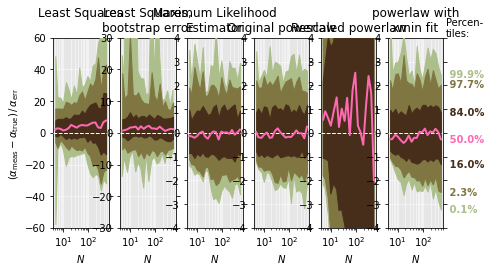

In [11]:
# Comment out the methods which are not needed.
methods = [
    "lstsq",
    "lstsq_bootstrap_err",
    "direct_MLE",
    "powerlaw",
    "powerlaw_rescaled",
    "powerlaw_xmin_fit",
]
num_methods = len(methods)
alpha = -1

plt.figure(figsize=(7, 3.5))

# Colors taken from seaborn cubehelix
colors = [[0.673, 0.746, 0.543], [0.500, 0.462, 0.259], [0.278, 0.179, 0.101]]

for j, method_name in enumerate(methods):
    # Use large number of trials (num_trials>1000) for good measurements of outlying percentiles.
    # Bootstrap fit can take time, so saving / loading the calculation results may be useful.
    fit = ExaminePowerLawFits(alpha=alpha, sample_size_grid=None, num_trials=100)  
    dev_dict = fit.calculate_fit_deviation(method_name)
    # np.save(method_name + ".npy", dev_dict, allow_pickle=True)
    # dev_dict = np.load(method_name+".npy",  allow_pickle=True)
    dev = dev_dict["deviation"]

    ax = plt.subplot2grid((1, num_methods), (0, j), title=dev_dict["label"])
    ax.set_facecolor("0.9")

    for i in range(3):
        plt.fill_between(
            dev_dict["samples"], dev[i, :], dev[6 - i, :], color=colors[i], zorder=7 + i
        )

    plt.plot(dev_dict["samples"], dev[3, :], lw=2, color="HotPink", zorder=11)
    plt.axhline(0, lw=1, ls="--", color="w", zorder=10)
    if j == (len(methods) - 1):
        colors_label = [
            colors[0],
            colors[1],
            colors[2],
            "HotPink",
            colors[2],
            colors[1],
            colors[0],
        ]
        plt.annotate(
            "Percen-\ntiles:", (770, 4.4), annotation_clip=False, color="k", va="center"
        )
        for i_k, k in enumerate(fit.percentiles):
            plt.annotate(
                "% 2.1f%%" % k,
                (770, dev[i_k, -1]),
                annotation_clip=False,
                color=colors_label[i_k],
                va="center",
                weight="bold",
            )
    if j == 0:
        plt.ylabel(
            r"$(\alpha_\mathrm{meas} - \alpha_\mathrm{true})\,/\,\alpha_{\mathrm{err}}$"
        )

    plt.semilogx()
    plt.xlabel(r"$N$")
    if method_name == "lstsq":
        ylim = 60
    elif method_name == "lstsq_bootstrap_err":
        ylim = 30
    else:
        ylim = 4
    plt.ylim(-ylim, ylim)
    plt.grid(color="w", zorder=20, which="both", lw=0.5)
    plt.tick_params(
        labelbottom=True,
        labeltop=False,
        labelleft=True,
        labelright=False,
        bottom=True,
        top=False,
        left=True,
        right=True,
    )  

plt.show()


D) Demonstrating that power-law indices measured with MLE method are described by gamma distribution (James et al 2019).

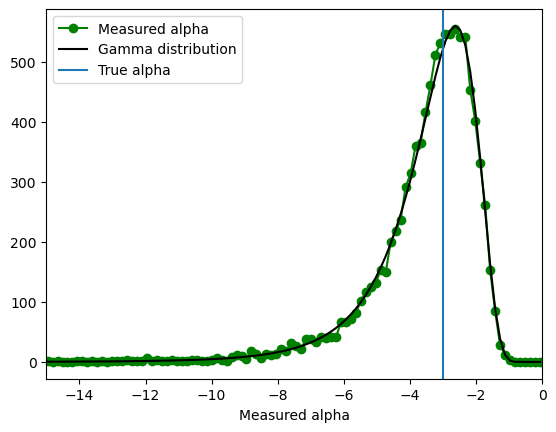

In [12]:

alpha_true = -3.0
num_points = 8
num_trials = 10000
alpha_measured = np.zeros(num_trials)
for i in range(num_trials):
    y = simulate_power_law_rv(alpha_true, num_points=num_points)
    alpha_measured[i], _ = fit_power_law_MLE(y)

plt.figure()
bins = np.linspace(-60, 0, 400)
alpha_measured_hist, _ = np.histogram(alpha_measured, bins=bins)
bin_centers = 0.5 * (bins[1:] + bins[:-1])
M = num_points - 1
# See Eq. 5 in James et al. (2019)
p = 1.0 / (-bin_centers) ** (M + 1) * np.exp(-alpha_true * M / bin_centers)
p = p / np.sum(p) * np.sum(alpha_measured_hist)

plt.plot(bin_centers, alpha_measured_hist, "go-", label="Measured alpha")
plt.plot(bin_centers, p, "k", label="Gamma distribution")
plt.axvline(alpha_true, label="True alpha")
plt.legend(loc=0)
plt.xlim(-15, 0)
plt.xlabel("Measured alpha")
plt.show()
